In [1]:
%matplotlib qt
import os
import pickle
from sdypy import EMA
import numpy as np
import matplotlib.pyplot as plt 
from EMA_functions import *
import pandas as pd
import matplotlib.animation as animation
import matplotlib.cm as cm
import matplotlib.colors as col
import ast

c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
df = pd.read_csv('H:/My Drive/PHD/HSC/file_descriptions_wlocs.csv')
file_name_basis = 'Full_web_ecc2_new2_Floc18_v'
v_vec = [5]
file_name_vec = [file_name_basis + str(x) for x in v_vec]
file_name_vec_video = [x + '_S01.cihx' for x in file_name_vec]
df_filtered = df[df['filename'].isin(file_name_vec_video)]
df_filtered

file_name = file_name_vec_video[0]
file_name_EMAs = os.path.splitext(file_name_vec[0])[0] + '_1d_and_2d_roi3x3'#'_1d_and_2d_roi3x3'
root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/EMA structure'
prey_ij = ast.literal_eval(df_filtered['prey_ij'].item())
df_filtered

filename  \
123  Full_web_ecc2_new2_Floc18_v5_S01.cihx   

                                                  path  ecc  loc  mass  \
123  H:\My Drive\PHD\HSC\ecc2\web1\Full_web_ecc2_ne...    2   18  True   

    taut/loose impact/pluck  version  n_frames     fps  Oversatured pixels  \
123      Loose       Impact        5      8000  8000.0                 727   

     Undersatured pixels     prey_ij   spider_ij  
123                18127  (356, 234)  (553, 229)

In [3]:
with open(os.path.join(root, file_name_EMAs + '.pkl'), 'rb') as f:
    EMA_structure = pkl.load(f)
video = EMA_structure.open_video()
EMA_structure.open_impact_data()

H:/My Drive/PHD/HSC\ecc2\web1\Full_web_ecc2_new2_Floc18_v5_S01\Full_web_ecc2_new2_Floc18_v5_S01.cihx


c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 8000, Original total frame: 87371)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


Switch between 1D and 2D here!

In [4]:
# EMA_structure.tp = EMA_structure.maxima2d 
# EMA_structure.d  = EMA_structure.displacements2D_2Dpoints
# td = EMA_structure.d + +  EMA_structure.maxima2d.reshape(len(EMA_structure.maxima2d),1,2)

EMA_structure.tp = EMA_structure.maxima1d 
EMA_structure.d  = EMA_structure.displacements1D_1Dpoints
td = EMA_structure.d + +  EMA_structure.maxima1d.reshape(len(EMA_structure.maxima1d),1,2)

In [5]:
%matplotlib inline
peak_n = 4
sequential_image_n = 0
shift = 0
EMA_structure.nut_idx((prey_ij[0]+shift, prey_ij[1]+shift), exclude_high_amplitude = False, d_lim =25)
EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation = True, tp_nut = True, tp = False, valid_only=True)

(<Figure size 1800x800 with 1 Axes>, <Axes: >)

In [6]:
%matplotlib qt
ani = EMA_structure.play_video(video, range(300,video.N-1), interval=30, points=td)

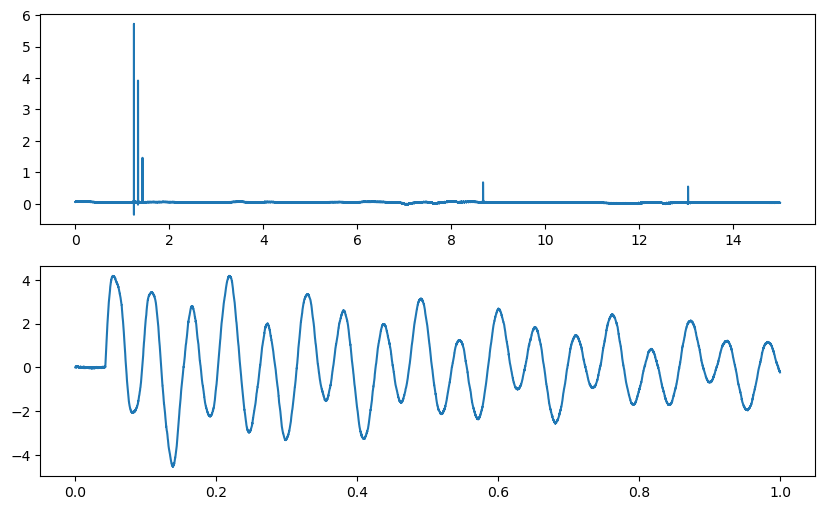

In [7]:
%matplotlib inline
EMA_structure.initialize_signals()
EMA_structure.initialize_displacement(idx='all', dir='y')
EMA_structure.t_camera_raw = EMA_structure.t_camera_raw
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(EMA_structure.t_force_raw, EMA_structure.force_raw)
ax[1].plot(EMA_structure.t_camera_raw, EMA_structure.displacements_raw[EMA_structure.nearest_nut_index])

In [8]:
first_zero_id_cam = EMA_structure.find_signal_start(EMA_structure.displacements_raw[EMA_structure.nearest_nut_index], treshold=0.08, approximate_height = 3)
first_zero_id_force = EMA_structure.find_signal_start(EMA_structure.force_raw, peak_n=peak_n, treshold=0.05)
zeros_camera    = EMA_structure.greatest_common_divisor(EMA_structure.fs_camera, EMA_structure.fs_force)
zeros_force     = EMA_structure.n_samples_camera_to_force(zeros_camera)

# Shift and align signals
EMA_structure.t_camera = EMA_structure.shift_time(EMA_structure.t_camera_raw, EMA_structure.t_camera_raw[first_zero_id_cam-zeros_camera])
EMA_structure.t_force = EMA_structure.shift_time(EMA_structure.t_force_raw, EMA_structure.t_force_raw[first_zero_id_force-zeros_force])

# Clip signals
EMA_structure.t_camera          = EMA_structure.clip_signal_before(EMA_structure.t_camera,first_zero_id_cam-zeros_camera)
EMA_structure.displacements     = EMA_structure.clip_signal_before(EMA_structure.displacements_raw, first_zero_id_cam-zeros_camera)
EMA_structure.t_force           = EMA_structure.clip_signal_before(EMA_structure.t_force, first_zero_id_force-zeros_force)
EMA_structure.force             = EMA_structure.clip_signal_before(EMA_structure.force_raw, first_zero_id_force-zeros_force)

last_id_force, last_id_camera   = EMA_structure.find_last_common_time_ids(EMA_structure.t_camera, EMA_structure.t_force)
EMA_structure.t_camera          = EMA_structure.clip_signal_after(EMA_structure.t_camera, last_id_camera)
EMA_structure.displacements     = EMA_structure.clip_signal_after(EMA_structure.displacements, last_id_camera)
EMA_structure.t_force           = EMA_structure.clip_signal_after(EMA_structure.t_force, last_id_force)
EMA_structure.force             = EMA_structure.clip_signal_after(EMA_structure.force, last_id_force)

# Zero Force after impact
EMA_structure.force = EMA_structure.zero_signal_treshold(EMA_structure.force, 0.1)

In [9]:
%matplotlib inline
fig, ax = plt.subplots(2,1,figsize=(20,5))
ax0_2 = ax[0].twinx()
ax1_2 = ax[1].twinx()
ax0_2.plot(EMA_structure.t_force, EMA_structure.force,'b-', label='Force (raw))')
ax[0].plot(EMA_structure.t_camera, EMA_structure.displacements[EMA_structure.nearest_nut_index,:],'r--', label=f'Displacement nut')
ax[0].set_xlim([-0.02, EMA_structure.t_camera[-1]])

ax[0].set_ylabel('pixels (-)')
ax0_2.set_ylabel('Force (N)')
ax[0].legend(loc='upper right')


ax1_2.plot(EMA_structure.t_force, EMA_structure.force,'b*-', label='Force')
ax[1].plot(EMA_structure.t_camera, EMA_structure.displacements[EMA_structure.nearest_nut_index,:],'r*--', label=f'Displacement nut')
# ax[1].plot(t_camera2[disp_peaks], disp_nut[disp_peaks], 'rx')
ax[1].set_xlim([0, 0.003])
ax[1].set_ylabel('pixels (-)')
ax1_2.set_ylabel('Force (N)')

# set legend to north east
ax1_2.legend()
ax[1].set_xlabel('Time (s)')
plt.show()
fig.savefig(os.path.join(EMA_structure.root_simulations, 'signals', f'{EMA_structure.file_name} - example impact.png'), dpi=300, bbox_inches='tight')

In [10]:
%matplotlib qt
# Feature filtering parameters for the 2D signals
# d_lim = 10
# z_limit = 0.2
# d_min = 0.9
# f_range = (3, 50)
# H_max_lim = 2e6
# H_peak_min = 2
# smooth_lim = 500
# max_drift = 1.

# Feature filtering parameters for the 1D signals
d_lim = 6
z_limit = 0.25
d_min = 0.5
f_range = (3, 50)
H_max_lim = 1e6
H_peak_min = 2
smooth_lim = 1.
max_drift = 2
max_end_drift = 1.5

EMA_structure.set_freq_properties(padding_ratio=1)
EMA_structure.get_transfer_function()
# EMA_structure.valid_tp(d_lim = 15, z_limit = 0.02, h_type = 'H1')
EMA_structure.valid_tp(d_lim = d_lim, z_limit = z_limit, h_type = 'H1', d_min=d_min, f_range= f_range)

smooth_signals = np.max(np.abs(np.diff(np.linalg.norm(EMA_structure.d, axis=2))), axis = 1) < smooth_lim
# non_drifting = np.abs(np.mean(np.linalg.norm(EMA_structure.d, axis=2), axis=1) < max_drift)
non_drifting = np.abs(np.mean(np.linalg.norm(EMA_structure.d[:,:-100], axis=2), axis=1) < max_drift)
non_drifting2 = np.abs(np.linalg.norm(EMA_structure.d[:,-1], axis=1)) < max_end_drift
H_max = np.max(np.abs(EMA_structure.H1), axis=1)
H_low = H_max<H_max_lim
H_peak_loc = np.argmax(np.abs(EMA_structure.H1), axis=1)
sd_points = H_peak_loc>H_peak_min

EMA_structure.valid_tps = EMA_structure.valid_tps  & smooth_signals & non_drifting & non_drifting2 & sd_points#& H_low
# EMA_structure.valid_tps =  smooth_signals & H_low & non_drifting & EMA_structure.valid_tps & sd_points# & non_drifting & H_low &

print(np.sum(~EMA_structure.exclude_outliers))
print(f'Number of valid points is: {len(EMA_structure.tp[EMA_structure.valid_tps])}/{EMA_structure.tp.shape[0]}')
ani = EMA_structure.play_video(video, range(300,video.N - 1), interval=30, points=td[EMA_structure.valid_tps])

# plt.figure(figsize=(15, 5))
# plt.semilogy(EMA_structure.freq_force, np.abs(EMA_structure.force_fft), label='Force')
# plt.semilogy(EMA_structure.freq_camera, np.abs(EMA_structure.disp_fft[EMA_structure.nearest_nut_index]), label='Displacement')

# plt.semilogy(freq_camera, np.abs(Disp[tp_id])/ np.abs(Force), label='output/input')
# plt.semilogy(freq_camera, np.abs(Disp[nearest_index]), label='Displacement nut')
# plt.plot(EMA_structure.freq_camera[], np.abs(EMA_structure.H1[EMA_structure.valid_tps[0]]), 'r', label='H1')
# for H1_i, peak_loc in zip(EMA_structure.H1[EMA_structure.valid_tps], H_peak_loc[EMA_structure.valid_tps]):
#     plt.semilogy(EMA_structure.freq_force, np.abs(H1_i), 'r', alpha=0.1, linewidth=0.2)
#     plt.semilogy(EMA_structure.freq_force[peak_loc], np.abs(H1_i[peak_loc]), 'ko', alpha=0.3)


# plt.xlim(f_range)
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Force [N], Displacment [m] amplitude spectra')
# plt.legend()

# coh = np.mean(np.abs(EMA_structure.H1[EMA_structure.valid_tps] / EMA_structure.H2[EMA_structure.valid_tps]), axis=0)
print(np.sum(~smooth_signals), np.sum(~non_drifting), np.sum(~non_drifting2), np.sum(~sd_points), np.sum(~H_low), np.sum(~EMA_structure.valid_tps))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for disp_i in EMA_structure.d[EMA_structure.valid_tps, :, 0]:
    ax.plot(EMA_structure.t_camera_raw, disp_i, 'r', alpha=0.2, linewidth=0.2)
# ax.plot(EMA_structure.t_camera, np.mean(EMA_structure.displacements[EMA_structure.valid_tps], axis=0), 'k', label='Mean displacement')

171
Number of valid points is: 5011/7200
2077 1371 1361 1474 819 2189


In [11]:
# large_x_motion = np.max(EMA_structure.d[EMA_structure.valid_tps, :, 1], axis=1)>.5
ani = EMA_structure.play_video(video, range(300,video.N - 1), interval=30, points=td[~smooth_signals])

In [12]:
smooth_signals2 = np.max(np.abs(np.diff(np.linalg.norm(EMA_structure.d, axis=2))), axis = 1) < 15
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for disp_i in EMA_structure.d[~smooth_signals & smooth_signals2, :, 0]:
    ax.plot(EMA_structure.t_camera_raw, disp_i, 'r', alpha=0.5, linewidth=0.5)
ax.set_ylim([-7, 7])

(-7.0, 7.0)

In [13]:
cam = EMA.Model(EMA_structure.H1[EMA_structure.valid_tps], EMA_structure.freq_camera, lower=5, upper=250, pol_order_high=120, frf_type = 'receptance')
cam.get_poles(show_progress=True)
# cam.Select_poles.chart_type = 1
cam.select_poles()


100%|█████████████████████████████████████████████████████████████| 120/120 [00:02<00:00, 54.48it/s]
c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\sdypy\EMA\EMA.py:888: RuntimeWarning: divide by zero encountered in divide
  p1L = np.kron(np.array([1, 0]), -1/omega**2)
c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\shape_base.py:1179: RuntimeWarning: invalid value encountered in multiply
  result = _nx.multiply(a_arr, b_arr, subok=(not is_any_mat))
c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\sdypy\EMA\EMA.py:889: RuntimeWarning: divide by zero encountered in divide
  p2L = np.kron(np.array([0, 1]), -1/omega**2)


In [14]:
cam.print_modal_data()
fig, ax = plot_FRF(cam)
fig.savefig(os.path.join(EMA_structure.root_simulations, 'FRFs', f'FRF_{EMA_structure.file_name}_1D_roi3x3_2.png'))  #_2D_roi5x5_2
fig = plot_MAC(cam)
fig[0].savefig(os.path.join(EMA_structure.root_simulations, 'MAC', f'MAC_{EMA_structure.file_name}_1D_roi3x3_2.png'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


   Nat. f.      Damping
-----------------------
1)    7.4	0.0127
2)   18.4	0.0102
3)   25.8	0.0023
4)   28.1	0.0166
5)   34.8	0.0189
6)   36.8	0.0106
7)   47.0	0.0082
8)   49.8	0.0225
9)   53.4	0.0019
10)   57.8	0.0162
11)   60.6	0.0102
12)   63.9	0.0198
13)   69.1	0.0082
14)   75.4	0.0057
15)   77.7	0.0041
16)   86.7	0.0039
17)   94.2	0.0043
18)  101.5	0.0059
19)  104.5	0.0043
20)  113.2	0.0036
21)  119.4	0.0012
22)  123.2	0.0018
23)  126.0	0.0034
24)  130.9	0.0032
25)  141.5	0.0014
26)  145.6	0.0023
27)  150.6	0.0039
28)  163.7	0.0041
29)  169.4	0.0016
30)  177.6	0.0016
31)  187.7	0.0007
32)  214.1	0.0011


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\sdypy\EMA\tools.py:71: ComplexWarning: Casting complex values to real discards the imaginary part
  MAC[i, j] = MAC[i, j]/\


In [ ]:
root_mode_shapes = os.path.join(EMA_structure.root_simulations, 'web mode shapes', EMA_structure.file_name + '_1D_roi3x3_2') #_1D_roi3x3

if not os.path.exists(root_mode_shapes):
    os.makedirs(root_mode_shapes)

for mode_number in range(len(cam.nat_freq)): # range(14,n_modes): #  [22]: # 
    print(f'mode_number: {mode_number}')
    ani  = animate_mode_shape(cam, mode_number, EMA_structure.tp[EMA_structure.valid_tps]) #, indices_to_plot = indices_to_plot np.delete(tp_lim, biggest_outliers, axis=0)
    writer = animation.FFMpegWriter(fps=60)
    ani.save(os.path.join(root_mode_shapes, f'Mode_shape_{EMA_structure.file_name}_{mode_number}.mp4'), writer=writer)
    plt.close()

In [17]:
plot_mode_shape(cam, 0, EMA_structure.tp[EMA_structure.valid_tps], EMA_structure.nearest_nut_index)

c:\Users\thijsmas\Documents\GitHub\pyidi\scripts\EMA_functions.py:790: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('seismic')


(<Figure size 1500x1387 with 1 Axes>,
 <Axes3D: title={'center': 'Mode 1 - 7.41 Hz'}, zlabel='Normalized mode shape'>)

In [34]:
%matplotlib inline
def plot_flat_mode_shape(cam, mode_number, tp, node, ax):
    A = cam.A
    A_imag = np.imag(A[:, mode_number])# / np.linalg.norm(A[:, mode_number])
    A_real = np.real(A[:, mode_number])# / np.linalg.norm(A[:, mode_number])

    node = np.argmax(np.abs(A[:, mode_number]))

    An_i = np.linalg.norm(A[node, mode_number])
    An_r = np.linalg.norm(A[node, mode_number])
    t_vec = np.linspace(0, 2 * np.pi, 100)
    A_max = 0
    t_max = 0
    for t in t_vec:
        A = An_i * np.sin(t) + An_r * np.cos(t)
        if A < A_max:
            A_max = A
            t_max = t

    Z = A_imag * np.sin(t_max) + A_real * np.cos(t_max)
    cmap = plt.cm.get_cmap('seismic')
    ax.scatter(tp[:, 1], -tp[:, 0], c=Z, cmap=cmap, s=2)
    return ax
fn_n = len(cam.nat_freq)
rows, columns  = (4,8)
fig, ax = plt.subplots(rows, columns, figsize=(20, 11))
for mode in range(fn_n):
    mode_i, mode_j = np.unravel_index(mode, (rows, columns))
    plot_flat_mode_shape(cam, mode, EMA_structure.tp[EMA_structure.valid_tps], EMA_structure.nearest_nut_index+1, ax[mode_i, mode_j])
    ax[mode_i, mode_j].set_xticks([])
    ax[mode_i, mode_j].set_yticks([])
    ax[mode_i, mode_j].set_title(f'{mode+1}: {cam.nat_freq[mode]:.1f} Hz')